<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/Mod%C3%A8le000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
import os
from tensorflow.python.client import device_lib
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])
print()
print()
from google.colab import files
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.layers import Layer
import matplotlib.gridspec as gridspec
from keras.models import Sequential
from keras.layers import Dense, Dropout,concatenate,Subtract,Multiply,Average, Concatenate,Reshape, Add, BatchNormalization
from keras.layers import Reshape,Lambda
from keras.layers.core import Activation
from keras.optimizers import SGD, Adam
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D,MaxPooling2D
import keras.losses
from keras.layers.core import Flatten
from keras import backend as K
import numpy as np
import scipy
from PIL import Image
from keras.layers import Input
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
noises = []

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TIPE
Utilise le CPU




Using TensorFlow backend.


In [0]:
# Install latest Tensorflow build
# !pip install -q tf-nightly-2.0-preview
# from tensorflow import summary
# %load_ext notebook

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [5]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy /= np.max(imageSortieTensorCopy)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
index = np.arange(0,len(images))
np.random.shuffle(index)
trainingData = [images[i] for i in index[:int(0.6*len(images))]]
evalData = [images[i] for i in index[int(0.6*len(images))-1:]]

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

In [17]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

W0727 12:23:08.702252 140138252363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Discriminateur

In [0]:
def discriminateur():
    inpt = Input(shape = (199, 199, 3),name='Image')
    Lsummary = []
    with K.name_scope('Bruit'):
        bruit = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(inpt)
        bruit = BatchNormalization()(bruit)
        bruit = Activation(SELU)(bruit)
        bruit = Convolution2D(filters=3,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(bruit)
        bruit = BatchNormalization()(bruit)
        bruit = Activation(SELU)(bruit)
        bruit = Subtract()([inpt,bruit])
        bruit = MaxPooling2D(pool_size=3,padding='VALID')(bruit)
        bruit1 = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(bruit)
        bruit1 = BatchNormalization()(bruit)
        bruit1 = Activation(SELU)(bruit)
        bruit1 = Convolution2D(filters=3,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME')(bruit)
        bruit1 = BatchNormalization()(bruit)
        bruit1 = Activation(SELU)(bruit)
        bruit1 = Subtract()([bruit,bruit1])
        bruit = MaxPooling2D(pool_size=3,padding='VALID')(bruit1)
    
    
    def inception(prevShapes):
        import time
        LsummaryInception = []
        inpt = Input(shape = prevShapes)
        coucheT0 = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(inpt)

        coucheT1 = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(inpt)
        coucheT1 = Convolution2D(filters=100,kernel_size=(1,3),activation=None,strides=(1,1),padding='SAME')(coucheT1)
        coucheT1 = Convolution2D(filters=100,kernel_size=(3,1),activation=None,strides=(1,1),padding='SAME')(coucheT1)

        couche = Concatenate(axis=-1)([coucheT0,coucheT1])
        couche = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(couche)
        couche = Add()([couche,inpt])
        
        return Model(input=inpt,output=couche,name='Inception_%f'%(time.time()))
    
    with K.name_scope('Traitement_image'):
        coucheAdaptation = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME')(inpt)
        inceptionModel = inception(coucheAdaptation.get_shape().as_list()[1:])
        image = inceptionModel(coucheAdaptation)
        image = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(image)
        image = BatchNormalization()(image)
        image = Activation(SELU)(image)
        image = MaxPooling2D(pool_size=3,padding='VALID')(image)
        inceptionModel = inception(image.get_shape().as_list()[1:])
        image = inceptionModel(image)
        image = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(image)
        image = BatchNormalization()(image)
        image = Activation(SELU)(image)
        image = MaxPooling2D(pool_size=3,padding='VALID')(image)
        inceptionModel = inception(image.get_shape().as_list()[1:])
        image = inceptionModel(image)
        image = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(image)
        image = BatchNormalization()(image)
        image = Activation(SELU)(image)
    
    resultatAnalyse = Concatenate(axis=-1)([bruit,image])
    resultatAnalyse = Flatten()(resultatAnalyse)
    resultatAnalyse = Dense(500)(resultatAnalyse)
    resultatAnalyse = Dropout(rate=0.25)(resultatAnalyse)
    resultatAnalyse = Activation(SELU)(resultatAnalyse)
    probabilite = Dense(1)(resultatAnalyse)
    probabilite = Activation('sigmoid')(probabilite)
    return Model(input=inpt,output=probabilite,name='Discriminateur')

In [0]:
# cf https://stackoverflow.com/questions/43784921/how-to-display-custom-images-in-tensorboard-using-keras?noredirect=1#comment85726690_43784921
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    height, width = tensor.shape
    image = Image.fromarray(tensor).convert('RGB')
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    CHANNEL = 1
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=CHANNEL,
                         encoded_image_string=image_string)

In [0]:
def sauvegardeModele(entree,model,iteration_entrainement,summary_writer,batch_size=7):
    list_layers = [[layer.name,layer.get_output_at(-1),layer] for layer in model.layers][1:]
    for layer_element in list_layers:
        layer_name,layer_output,layer = layer_element
        model_calcul_image = Model(input=model.input,output=layer_output)
        sortie_couche = model_calcul_image.predict(entree, batch_size=batch_size)
        dim_sortie = sortie_couche.shape
        if len(dim_sortie) == 4:
            for canal_image in range(dim_sortie[-1]):
                summary_image = tf.Summary(value=[tf.Summary.Value(tag=layer_name+'_canal_'+str(canal_image), 
                                         image=make_image(sortie_couche[0,:,:,canal_image]))])
                summary_writer.add_summary(summary_image,iteration_entrainement)
    summary_writer.close()
    summary_writer.reopen()
    return None

In [0]:
def train(images,eval_data,pathTmpSave,indexModele):
    pathTmpSave = pathTmpSave + 'Modele'+str(indexModele)+'_Disc.h5'
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc = discriminateur()
    print(disc.summary())
    Lloss = []
    Lresult = []
    disc.compile(loss='logcosh', optimizer=d_optim)
    from keras.utils import plot_model
    plot_model(disc, to_file='Modele'+str(indexModele)+'_Disc',show_shapes=True,show_layer_names=True)
    
    summary_writer = tf.summary.FileWriter(logdir='./logs/Modele'+str(indexModele)+'_Disc',graph=tf.get_default_graph())
    
    nbEpoch = 200
    i = 0
    rep = 2
    while i < nbEpoch:
        disc.save_weights(pathTmpSave)
        image2,imageBruitee2 = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        
        current_learning_rate = tauxApprentissage(i,10**-4,10,10**-5)
        K.set_value(disc.optimizer.lr, current_learning_rate)
        
        entree = np.concatenate((image2, imageBruitee2))
        sortie = np.array(7* [1] + 7*[0])
        loss = disc.train_on_batch(entree,sortie)
        Lloss.append(loss)
        if np.isnan(loss) == True and i < 10:
            disc = discriminateur()
            disc.compile(loss='logcosh', optimizer=d_optim)
            i = 0
            print("Reset")
        elif np.isnan(loss) == True and rep > 0:
            disc.load_weights(pathTmpSave)
            nbEpoch += 1
            rep -= 1
            Lresult = []
        elif np.isnan(loss) == True and rep == 0:
            break
            
        else:
            rep = 10
        print("Epoch %i, loss %f"%(i,loss))
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur : Logcosh", 
                                             simple_value=loss) ])
        summary_writer.add_summary(summary_loss,i)
        if i % 49 == 0:
            sauvegardeModele(entree,disc,i,summary_writer,batch_size=7)
        Lloss.append(loss)
        i += 1
    
    return Lloss
Lloss = train(trainingData, evalData,'./Restore/',1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Inception_1563549897.521545", inputs=Tensor("Tr..., outputs=Tensor("Tr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Inception_1563549897.708283", inputs=Tensor("Tr..., outputs=Tensor("Tr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Inception_1563549897.901590", inputs=Tensor("Tr..., outputs=Tensor("Tr...)`
W0719 15:24:58.047202 140609842673536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate =

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image (InputLayer)              (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 199, 199, 100 400         Image[0][0]                      
__________________________________________________________________________________________________
Inception_1563549897.521545 (Mo (None, 199, 199, 100 100500      conv2d_185[0][0]                 
__________________________________________________________________________________________________
lr_n2d_28 (LRN2D)               (None, 199, 199, 100 0           Inception_1563549897.521545[1][0]
__________________________________________________________________________________________________
batch_norm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("Tr...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("Br...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("co...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("fl...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("de...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model

Epoch 1, loss 0.162400
Epoch 2, loss 0.193431
Epoch 3, loss 0.182119
Epoch 4, loss 0.140434
Epoch 5, loss 0.112518
Epoch 6, loss 0.130877
Epoch 7, loss 0.104991
Epoch 8, loss 0.148660
Epoch 9, loss 0.100008
Epoch 10, loss 0.041876
Epoch 11, loss 0.118191
Epoch 12, loss 0.029929
Epoch 13, loss 0.091597
Epoch 14, loss 0.115697
Epoch 15, loss 0.100794
Epoch 16, loss 0.068363
Epoch 17, loss 0.109097
Epoch 18, loss 0.077566
Epoch 19, loss 0.044812
Epoch 20, loss 0.040720
Epoch 21, loss 0.103823
Epoch 22, loss 0.047190
Epoch 23, loss 0.053478
Epoch 24, loss 0.079487
Epoch 25, loss 0.072721
Epoch 26, loss 0.085456
Epoch 27, loss 0.082768
Epoch 28, loss 0.040946
Epoch 29, loss 0.065589
Epoch 30, loss 0.040821
Epoch 31, loss 0.068556
Epoch 32, loss 0.050092
Epoch 33, loss 0.035736
Epoch 34, loss 0.050636
Epoch 35, loss 0.063486
Epoch 36, loss 0.029868
Epoch 37, loss 0.027689
Epoch 38, loss 0.109195
Epoch 39, loss 0.094627
Epoch 40, loss 0.076842
Epoch 41, loss 0.052171
Epoch 42, loss 0.090465
E

In [0]:
def generateur():
    inpt = Input(shape = (199, 199, 3),name='ImageATraiter')
    couche = Dense(500)(inpt)
    couche = Dropout(rate=0.25)(couche)
    couche = LRN2D(n=21,k=2,alpha=10**-4,beta=0.75)(couche)
    couche = Activation(SELU)(couche)
    couche = Dense(100)(couche)
    couche = BatchNormalization()(couche)	
    couche = Activation(SELU)(couche)
    couche = Dense(3)(couche)
    couche = BatchNormalization()(couche)	
    couche = Activation(SELU)(couche)
    couche = Add()([inpt,couche])
    return Model(input=inpt,output=couche,name='Generateur')

In [0]:
def top_10(gen,x,y,indexModele):
    Lloss = []
    orig_backup = "_tmp_Modele"+str(indexModele)+"_gen_orig.h5"
    gen.save_weights(orig_backup)
    for i in range(10):
        backup_path = "_tmp_Modele"+str(indexModele)+"_gen_"+str(i)+".h5"
        gen.load_weights(orig_backup)
        loss = gen.train_on_batch(x,y)
        gen.save_weights(backup_path)
        Lloss.append([loss,backup_path])
    Lloss.sort(key=lambda elem:elem[0])
    gen.load_weights(Lloss[0][1])
    return Lloss[0][0]

In [0]:
def preTrainGenerateur(images,eval_data,pathTmpSave,indexModele):
    gen = generateur()
    optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    gen.compile(loss='mean_absolute_error', optimizer=optim)
    print(gen.summary())
    from keras.utils import plot_model
    plot_model(gen, to_file='modele_gereteur_Modele%i.png'%(indexModele),show_shapes=True,show_layer_names=True)
    i = 0
    Lanalyse = []
    Lloss = []
    nbEpoch = 500
    repetition_limit = 10
    repetition_state = 0
    while i < nbEpoch:
        image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        current_learning_rate = tauxApprentissage(i,10**-4,10,10**-7)
        K.set_value(gen.optimizer.lr, current_learning_rate)
        if i % 10 == 0:
            predictedImage = convertToUint(gen.predict(image))
            predictedImageBruitee = convertToUint(gen.predict(imageBruitee))
            Lanalyse.append([image,predictedImage,imageBruitee,predictedImageBruitee])
        x = np.concatenate((image,imageBruitee))
        y = np.concatenate((image,image))
        loss = top_10(gen,x,y,indexModele)
        print("Loss %i : %f"%(i,loss))
        Lloss.append(loss)
        i += 1
    return Lloss,Lanalyse
Lloss,Lanalyse = preTrainGenerateur(trainingData, evalData,'./Restore/',1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Generateur", inputs=Tensor("Im..., outputs=Tensor("ac...)`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageATraiter (InputLayer)   (None, 199, 199, 3)       0         
_________________________________________________________________
dense_10 (Dense)             (None, 199, 199, 500)     2000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 199, 199, 500)     0         
_________________________________________________________________
lr_n2d_4 (LRN2D)             (None, 199, 199, 500)     0         
_________________________________________________________________
activation_11 (Activation)   (None, 199, 199, 500)     0         
_________________________________________________________________
dense_11 (Dense)             (None, 199, 199, 100)     50100     
_________________________________________________________________
batch_normalization_7 (Batch (None, 199, 199, 100)     400       
__________

In [0]:
def mean_gen_disc_top_9(disc,gen_disc,x,indexModele):
    disc_orig_backup = "Modele"+str(indexModele)+"_global_disc_orig.h5"
    disc_gen_orig_backup = "Modele"+str(indexModele)+"_global_gen_disc_orig.h5"
    # On commence par faire 3 essais avec le gen_disc
    Lloss_gen_disc = []
    Lloss_tot = []
    disc.save_weights(disc_orig_backup)
    gen_disc.save_weights(disc_gen_orig_backup)
    y = [1]*x.shape[0]
    for i in range(3):
        try:
            gen_disc.load_weights(disc_gen_orig_backup)
        except:
            gen_disc.load_weights(disc_gen_orig_backup)
        loss = gen_disc.train_on_batch(x,y)
        gen_disc_backup = "Modele"+str(indexModele)+"_global_gen_disc_%i.h5"%(i)
        try:
            gen_disc.save_weights(gen_disc_backup)
        except:
            gen_disc.save_weights(gen_disc_backup)
        Lloss_gen_disc.append([loss,gen_disc_backup])
    y = [1]*(x.shape[0]//2)+[0]*(x.shape[0]//2)
    for index_gen_disc,loss_pathBackup in enumerate(Lloss_gen_disc):
        for i in range(3):
            print("loss_pathBackup[1]",loss_pathBackup[1])
            try:
                gen_disc.load_weights(loss_pathBackup[1])
            except:
                gen_disc.load_weights(loss_pathBackup[1])
            loss = disc.train_on_batch(x,y)
            disc_backup = "Modele"+str(indexModele)+"_global_disc_branche_%i_essai_%i.h5"%(index_gen_disc,i)
            try:
                disc.save_weights(disc_backup)
            except:
                disc.save_weights(disc_backup)
            Lloss_tot.append([loss_pathBackup[0],loss_pathBackup[1],loss,disc_backup,np.mean([loss_pathBackup[0],loss])])
    Lloss_tot.sort(key=lambda elem:elem[-1])
    try:
        gen_disc.load_weights(Lloss_tot[0][1])
        disc.load_weights(Lloss_tot[0][-2])
    except:
        gen_disc.load_weights(Lloss_tot[0][1])
        disc.load_weights(Lloss_tot[0][-2])
        
    print("Resultat top 9 : ",Lloss_tot)
    return Lloss_tot[0]

In [0]:
def sauvegardeModele(entree,model,iteration_entrainement,summary_writer,batch_size=7):
    list_layers = [[layer.name,layer.get_output_at(-1),layer] for layer in model.layers][1:]
    for layer_element in list_layers:
        layer_name,layer_output,layer = layer_element
        model_calcul_image = Model(input=model.get_input_at(0),output=layer_output)
        sortie_couche = model_calcul_image.predict(entree, batch_size=batch_size)
        dim_sortie = sortie_couche.shape
        if len(dim_sortie) == 4:
            for canal_image in range(dim_sortie[-1]):
                summary_image = tf.Summary(value=[tf.Summary.Value(tag=layer_name+'_canal_'+str(canal_image), 
                                         image=make_image(sortie_couche[0,:,:,canal_image]))])
                summary_writer.add_summary(summary_image,iteration_entrainement)
    return None

In [0]:
def gen_disc_model(gen,disc):
    inpt = Input(shape = (199, 199, 3))
    couche = gen(inpt)
    couche = disc(couche)
    return Model(input=inpt, output=couche)

In [27]:
def train_gen_disc(images,eval_data,indexModele):
    gen = generateur()
    gen_backup = "_tmp_Modele"+str(indexModele-2)+"_gen_orig.h5"
    gen.load_weights(gen_backup)
    gen_disc_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc = discriminateur()
    disc_backup = "./Restore/" + 'Modele'+str(indexModele-2)+'_Disc.h5'
    disc_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc.compile(loss='binary_crossentropy', optimizer=disc_optim)
    disc.load_weights(disc_backup)
    gen_disc = gen_disc_model(gen,disc)
    gen_disc.compile(loss='binary_crossentropy', optimizer=gen_disc_optim)
    print(gen_disc.summary())
    print(disc.summary())
    Lloss = []
    iterations = 500
    index = 0
    import datetime
    chaine_date = datetime.datetime.today().strftime('%Y-%m-%d_%Hh%Mmin%Ss') #cf http://strftime.org/ et https://www.science-emergence.com/Articles/Obtenir-la-date-daujourdhui-au-format-YYYY-MM-DD-avec-python/
    summary_writer = tf.summary.FileWriter(logdir='./logs/Modele'+str(indexModele)+'_gen_disc_'+chaine_date,graph=tf.get_default_graph())
    while index < iterations:
        image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        current_learning_rate = tauxApprentissage(index,10**-4,10,10**-7)
        K.set_value(disc.optimizer.lr, current_learning_rate)
        K.set_value(gen_disc.optimizer.lr, current_learning_rate)
        x = np.concatenate((image,imageBruitee))
        loss = mean_gen_disc_top_9(disc,gen_disc,x,indexModele)
        Lloss.append(loss)
        print("Iteration %i : gen_disc, erreur : %f ; disc, erreur : %f ; erreur moyenne : %f"%(index,loss[0],loss[2],loss[-1]))
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur gen-disc : binary-crossentropy", 
                                             simple_value=loss[0]) ])
        summary_writer.add_summary(summary_loss,index)
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur disc : binary-crossentropy", 
                                             simple_value=loss[2]) ])
        summary_writer.add_summary(summary_loss,index)
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur moyenne : binary-crossentropy", 
                                             simple_value=loss[-1]) ])
        summary_writer.add_summary(summary_loss,index)
        if index % 5 == 0:
            sauvegardeModele(x,gen,index,summary_writer)
            sauvegardeModele(x,disc,index,summary_writer)
            summary_writer.close()
            summary_writer.reopen()
        index += 1
Lloss = train_gen_disc(images,evalData,3)

W0727 12:23:21.278752 140138252363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 12:23:21.291777 140138252363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 12:23:21.324561 140138252363648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 12:23:21.337370 140138252363648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Ins

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 199, 199, 3)       0         
_________________________________________________________________
Generateur (Model)           (None, 199, 199, 3)       52815     
_________________________________________________________________
Discriminateur (Model)       (None, 1)                 25230145  
Total params: 25,282,960
Trainable params: 25,282,146
Non-trainable params: 814
_________________________________________________________________
None
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image (InputLayer)              (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("de...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("dr...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("lr...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("ac...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Im..., outputs=Tensor("ba...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model

loss_pathBackup[1] Modele3_global_gen_disc_0.h5
loss_pathBackup[1] Modele3_global_gen_disc_0.h5
loss_pathBackup[1] Modele3_global_gen_disc_0.h5
loss_pathBackup[1] Modele3_global_gen_disc_1.h5
loss_pathBackup[1] Modele3_global_gen_disc_1.h5
loss_pathBackup[1] Modele3_global_gen_disc_1.h5
loss_pathBackup[1] Modele3_global_gen_disc_2.h5
loss_pathBackup[1] Modele3_global_gen_disc_2.h5
loss_pathBackup[1] Modele3_global_gen_disc_2.h5
Resultat top 9 :  [[0.3711379, 'Modele3_global_gen_disc_1.h5', 0.38858658, 'Modele3_global_disc_branche_1_essai_1.h5', 0.37986225], [0.3711379, 'Modele3_global_gen_disc_1.h5', 0.56127936, 'Modele3_global_disc_branche_1_essai_0.h5', 0.46620864], [0.5756883, 'Modele3_global_gen_disc_2.h5', 0.41471317, 'Modele3_global_disc_branche_2_essai_1.h5', 0.49520075], [0.3711379, 'Modele3_global_gen_disc_1.h5', 0.6333703, 'Modele3_global_disc_branche_1_essai_2.h5', 0.50225407], [0.5756883, 'Modele3_global_gen_disc_2.h5', 0.454406, 'Modele3_global_disc_branche_2_essai_0.h5', 

KeyboardInterrupt: ignored

In [0]:
x = list(range(len(Lloss)))
yMoy = []
nb = 3
for i in range(len(Lloss)):
    if i+nb >= len(Lloss):
        yMoy.append(np.mean(Lloss[i:]))
    else:
        yMoy.append(np.mean(Lloss[i:i+nb]))
plt.plot(x,yMoy)

coeff = np.polyfit(x,yMoy,4)
reg = [elem**4*coeff[0]+elem**3*coeff[1]+elem**2*coeff[2]+elem**1*coeff[3]+coeff[4] for elem in x]
plt.plot(x,reg,linestyle='--')
plt.grid()

# Essai de la fonction Model

In [0]:
def discriminateur():
    inpt = Input(shape = (199, 199, 3),name='Input')
    coucheConv = Convolution2D(3,(2,2),activation='relu')(inpt)
    couche = Flatten()(coucheConv)
    couche = Dense(1)(couche)
    model = Model(inputs=inpt, outputs=couche)
    modelVisu = Model(inputs=inpt, outputs=coucheConv)
    return model,modelVisu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 199, 199, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 198, 198, 3)       39        
_________________________________________________________________
flatten_5 (Flatten)          (None, 117612)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 117613    
Total params: 117,652
Trainable params: 117,652
Non-trainable params: 0
_________________________________________________________________
None
Epoch 0, loss 0.519768
Epoch 1, loss 0.534919
Epoch 2, loss 0.498878
Epoch 3, loss 0.520071
Epoch 4, loss 0.512690
Epoch 5, loss 0.505182
Epoch 6, loss 0.509437
Epoch 7, loss 0.495167
Epoch 8, loss 0.499577
Epoch 9, loss 0.511728


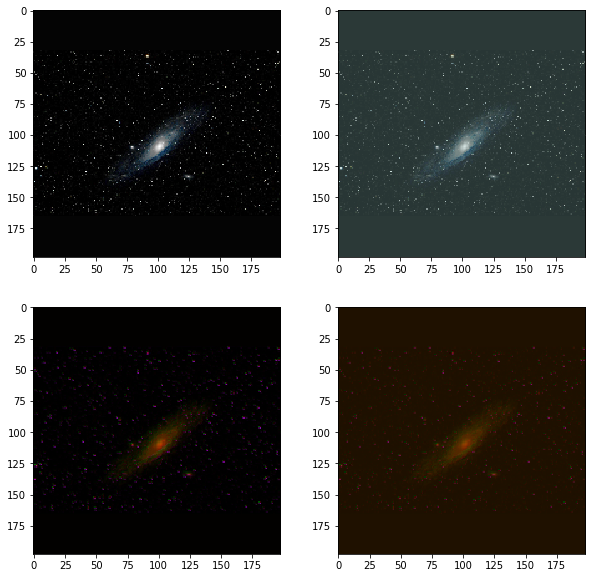

In [0]:
def train(images,eval_data):
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc,modelVisu = discriminateur()
    print(disc.summary())
    Lloss = []
    Lresult = []
    def lossF(y_true,y_pred):
        return K.abs(y_true-y_pred)
    disc.compile(loss=lossF, optimizer=d_optim)
    nbEpoch = 10
    i = 0
    rep = 2
    while i < nbEpoch:
        disc.save_weights("_tmp_testFonctionModel.h5")
        image2,imageBruitee2 = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        current_learning_rate = tauxApprentissage(i,10**-4,10,10**-5)
        K.set_value(disc.optimizer.lr, current_learning_rate)
        X = np.concatenate((image2, imageBruitee2))
        y = np.array(7* [1] + 7*[0])
        loss = disc.train_on_batch(X,y)
        if np.isnan(loss) == True and i < 10:
            disc,modelVisu = discriminateur()
            disc.compile(loss=lossF, optimizer=d_optim)
            i = 0
            print("Reset")
        elif np.isnan(loss) == True and rep > 0:
            disc.load_weights("_tmp_testFonctionModel.h5")
            nbEpoch += 1
            rep -= 1
            Lresult = []
        elif np.isnan(loss) == True and rep == 0:
            break
            
        else:
            rep = 10
        print("Epoch %i, loss %f"%(i,loss))
        Lloss.append(loss)
        i += 1
    image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
    imageSortie = modelVisu.predict(image)
    imageBruiteeSortie = modelVisu.predict(imageBruitee)
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(convertToUint(image[0,:,:,:]))
    plt.subplot(2,2,2)
    plt.imshow(convertToUint(imageBruitee[0,:,:,:]))
    plt.subplot(2,2,3)
    plt.imshow(convertToUint(imageSortie[0,:,:,:]))
    plt.subplot(2,2,4)
    plt.imshow(convertToUint(imageBruiteeSortie[0,:,:,:]))
    
    return None
train(trainingData, evalData)